<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Happy--Sohyun/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Environment & path Setup 

Add our shared drive (ECS 171) as shortcut to MyDrive by right-clicking on ECS171 in Google Drive and clicking on Add Shortcut to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check current directory

In [ ]:
pwd

'/content'

Change directory

In [ ]:
%cd '/content/drive/MyDrive/ECS171/emotionDataSet'

/content/drive/.shortcut-targets-by-id/1Z5iKjOa4METq6Gspzm97KWYkNG2sG5Wo/ECS171/emotionDataSet


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1Z5iKjOa4METq6Gspzm97KWYkNG2sG5Wo/ECS171/emotionDataSet'

##Load Data

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [ ]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

In [ ]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
IMG_SIZE= (48, 48)

In [ ]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [09:37<00:00, 96.33s/it]


28721 images loaded from Training/Training/ directory.


In [ ]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [02:05<00:00, 20.99s/it]

7129 images loaded from Testing/Testing/ directory.


##Data exploration

Number of images for each class

In [ ]:
import pandas as pd

_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})
data

,train,test,emotion
0,4056,976,Angry
1,4127,1034,Fear
2,7235,1774,Happy
3,5242,1267,Neutral
4,4870,1247,Sad
5,3191,831,Suprise


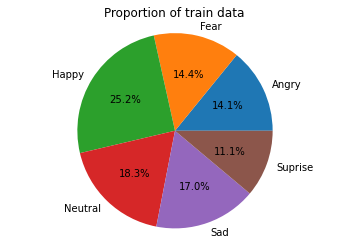

In [ ]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0),
       labels=emotions,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of train data")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



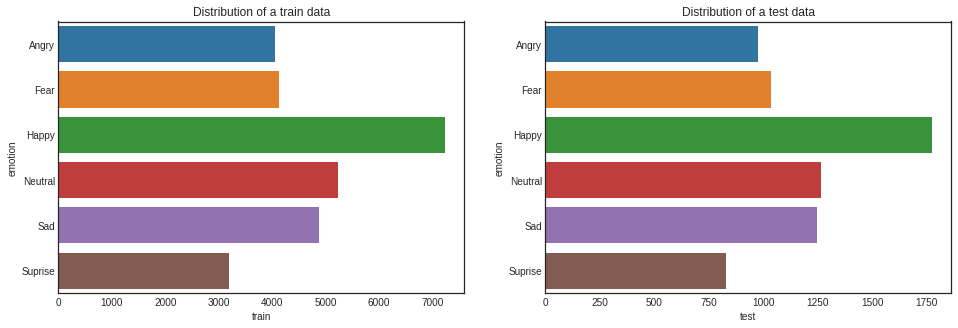

In [ ]:
import seaborn as sns

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(data["train"], data["emotion"], ax=ax[0])
ax[0].set_title("Distribution of a train data")
sns.barplot(data["test"], data["emotion"], ax=ax[1])
ax[1].set_title("Distribution of a test data")
plt.show()

Size of Images (Or the structures)

Standardization check

Plot samples of data _Arandi

##Data preprocessing

##Removing Duplicates

In [ ]:
import cv2  
from skimage.metrics import structural_similarity

image_list = []

path = TRAIN_DIR + '/Happy'

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 7235


In [ ]:
img_data

,filename,size
0,Happy-961.jpg,1297
1,Happy-6746.jpg,1460
2,Happy-6855.jpg,1558
3,Happy-6200.jpg,1417
4,Happy-6514.jpg,1538
...,...,...
7230,Happy-1573.jpg,1637
7231,Happy-2209.jpg,1572
7232,Happy-167.jpg,1620
7233,Happy-137.jpg,1509


In [ ]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
1603,Happy-6722.jpg,1907,1,4
4148,Happy-3125.jpg,1644,1,20


In [ ]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

Use structural similarity to compare similarity of images

In [ ]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [ ]:
delete = dict()

In [ ]:
for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    candidates = []

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          

Happy-6680.jpg, Happy-2461.jpg
score: 0.7168389603349193


Similar images

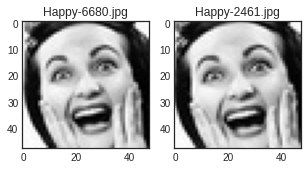

In [ ]:
plt.figure(0, figsize=(5,3))
ax = plt.subplot(1,2,1)
ax.set_title('Happy-6680.jpg')
img1 = cv2.imread(path+"/"+ 'Happy-6680.jpg')
plt.imshow(img1,cmap="gray")

ax = plt.subplot(1,2,2)
ax.set_title('Happy-2461.jpg')
img2 = cv2.imread(path+"/"+ 'Happy-2461.jpg')
plt.imshow(img2,cmap="gray")

In [ ]:
total = [len(value) for key, value in delete.items()]
print(str(sum(total)) + " duplicates found")

149 duplicates found


Plotting some duplicates to confirm they are the same

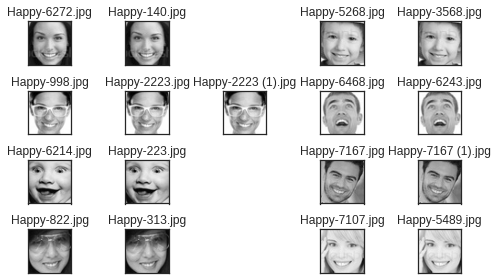

In [ ]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 8

for key in delete:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(4,6,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ key)
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  for file in delete[key]:
    cpt += 1
    ax = plt.subplot(4,6,cpt)
    ax.set_title(file)

    img = cv2.imread(path+"/"+ file)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")
    pass
  
  if (cpt % 3 != 0):
    cpt +=1
  n -= 1

plt.tight_layout()
plt.show()

In [ ]:
orig_list = image_list

print("original image number: " + str(len(orig_list)))

original image number: 7235


In [ ]:
for key in delete:
  for val in delete[key]:
    image_list.remove(val)

print("updated images number: " + str(len(image_list)))

updated images number: 7086


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1Z5iKjOa4METq6Gspzm97KWYkNG2sG5Wo/ECS171/emotionDataSet/Training/Training'

In [ ]:
os.chdir(os.getcwd() + '/Happy')

Remove images

In [ ]:
for key in delete:
  print("Removing duplicates of " + key)
  for val in delete[key]:
    print(val + " removed")
    os.remove(val)

Removing duplicates of Happy-6272.jpg
Happy-140.jpg removed
Removing duplicates of Happy-5268.jpg
Happy-3568.jpg removed
Removing duplicates of Happy-998.jpg
Happy-2223.jpg removed
Happy-2223 (1).jpg removed
Removing duplicates of Happy-6468.jpg
Happy-6243.jpg removed
Removing duplicates of Happy-6214.jpg
Happy-223.jpg removed
Removing duplicates of Happy-7167.jpg
Happy-7167 (1).jpg removed
Removing duplicates of Happy-822.jpg
Happy-313.jpg removed
Removing duplicates of Happy-7107.jpg
Happy-5489.jpg removed
Removing duplicates of Happy-4107.jpg
Happy-2538.jpg removed
Removing duplicates of Happy-4095.jpg
Happy-2378.jpg removed
Removing duplicates of Happy-3371.jpg
Happy-2342.jpg removed
Removing duplicates of Happy-3907.jpg
Happy-173.jpg removed
Removing duplicates of Happy-2760.jpg
Happy-598.jpg removed
Removing duplicates of Happy-307.jpg
Happy-4403.jpg removed
Happy-2818.jpg removed
Removing duplicates of Happy-5770.jpg
Happy-5770 (1).jpg removed
Removing duplicates of Happy-6723 (

##Removing outliers

##Grayscaling

Data Augmentation? (Shifting, Rotating, Brightness, Cropping ...)

##Encoding Classes

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

##Sources

Loading data & encoding: https://www.kaggle.com/code/basel99/facial-recognition